In [ ]:
import os
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from PIL import UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Animal Dataset Experiment

## Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
drive_path = '/content/drive/My Drive/9.s912/animal-kingdom'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Mounted at /content/drive


In [ ]:
df = pd.read_csv(os.path.join(drive_path, 'Animal Dataset.csv'))
print(f"We have features for {len(df.Animal)} animals.")

We have features for 205 animals.


In [ ]:
in_ds = pd.read_csv(os.path.join(drive_path,'matched_labels.csv'))
animals_with_features = df.Animal.tolist()

In [ ]:
in_ds.head()

,Unnamed: 0,ID,Class,Label,MatchedLabel
0,2,n02110185,3,Siberian_husky,Siberian Husky
1,8,n02417914,9,ibex,Alpine Ibex
2,23,n02504458,24,African_elephant,African Elephant
3,34,n02138441,35,meerkat,Meerkat
4,37,n02457408,38,three-toed_sloth,Three-Toed Sloth


In [ ]:
df.columns

Index(['Animal', 'Height (cm)', 'Weight (kg)', 'Color', 'Lifespan (years)',
       'Diet', 'Habitat', 'Predators', 'Average Speed (km/h)',
       'Countries Found', 'Conservation Status', 'Family',
       'Gestation Period (days)', 'Top Speed (km/h)', 'Social Structure',
       'Offspring per Birth'],
      dtype='object')

## Data Preparation

In [ ]:
images = os.listdir(os.path.join(drive_path, 'imagenet_folders'))
print(len(images))
img_data = []

for img in images:
  ID = img.split('_')[0]
  label = in_ds[in_ds['ID']==ID]['MatchedLabel'].tolist()[0]
  img_data.append([img, label, ID])

img_df = pd.DataFrame(data=img_data, columns=['ImagePath','Animal','ID'])
img_df.head()

58289


,ImagePath,Animal,ID
0,n02132136_8358.JPEG,Brown Bear,n02132136
1,n02132136_8455.JPEG,Brown Bear,n02132136
2,n02132136_8438.JPEG,Brown Bear,n02132136
3,n02132136_729.JPEG,Brown Bear,n02132136
4,n02132136_8386.JPEG,Brown Bear,n02132136


In [ ]:
print(f"We have {len(img_df.index)} images from {len(img_df['Animal'].unique().tolist())} animals.")

We have 58289 images from 45 animals.


In [ ]:
features = ['Lifespan (years)','Conservation Status','Gestation Period (days)','Average Speed (km/h)','Social Structure','Diet','Habitat',
            'Height (cm)','Weight (kg)','Top Speed (km/h)']
feature_df = df[['Animal'] + features]
feature_df.drop_duplicates(subset=['Animal'],inplace=True)
feature_df.set_index('Animal', inplace=True)
print(feature_df.head())
f0 = []
f1 = []
f2 = []
f3 = []
f4 = []
f5 = []
f6 = []
f7 = []
f8 = []
f9 = []

for i in range(len(img_df.index)):
  animal = img_df['Animal'][i]
  f0.append(feature_df[features[0]][animal])
  f1.append(feature_df[features[1]][animal])
  f2.append(feature_df[features[2]][animal])
  f3.append(feature_df[features[3]][animal])
  f4.append(feature_df[features[4]][animal])
  f5.append(feature_df[features[5]][animal])
  f6.append(feature_df[features[6]][animal])
  f7.append(feature_df[features[7]][animal])
  f8.append(feature_df[features[8]][animal])
  f9.append(feature_df[features[9]][animal])

img_df[features[0].split(' ')[0]] = f0
img_df[features[1].split(' ')[0]] = f1
img_df[features[2].split(' ')[0]] = f2
img_df[features[3].split(' ')[0]] = f3
img_df[features[4].split(' ')[0]] = f4
img_df[features[5].split(' ')[0]] = f5
img_df[features[6].split(' ')[0]] = f6
img_df[features[7].split(' ')[0]] = f7
img_df[features[8].split(' ')[0]] = f8
img_df[features[9].split(' ')[0]] = f9


                 Lifespan (years) Conservation Status Gestation Period (days)  \
Animal                                                                          
Aardvark                    20-30       Least Concern                 210-240   
Aardwolf                    10-12       Least Concern                      90   
African Elephant            60-70          Vulnerable                 640-660   
African Lion                10-14          Vulnerable                  98-105   
African Wild Dog            10-12          Endangered                      70   

                 Average Speed (km/h) Social Structure         Diet  \
Animal                                                                
Aardvark                           40         Solitary  Insectivore   
Aardwolf                        24-30         Solitary  Insectivore   
African Elephant                   25       Herd-based    Herbivore   
African Lion                       58      Group-based    Carnivore   
Africa

<ipython-input-12-a4b634bbc728>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df.drop_duplicates(subset=['Animal'],inplace=True)


In [ ]:
img_df

,ImagePath,Animal,ID,Lifespan,Conservation,Gestation,Average,Social,Diet,Habitat,Height,Weight,Top
0,n02132136_8358.JPEG,Brown Bear,n02132136,20-30,Least Concern,180-250,48,Solitary,Omnivore,"Forests, Mountains",70-120,70-780,48
1,n02132136_8455.JPEG,Brown Bear,n02132136,20-30,Least Concern,180-250,48,Solitary,Omnivore,"Forests, Mountains",70-120,70-780,48
2,n02132136_8438.JPEG,Brown Bear,n02132136,20-30,Least Concern,180-250,48,Solitary,Omnivore,"Forests, Mountains",70-120,70-780,48
3,n02132136_729.JPEG,Brown Bear,n02132136,20-30,Least Concern,180-250,48,Solitary,Omnivore,"Forests, Mountains",70-120,70-780,48
4,n02132136_8386.JPEG,Brown Bear,n02132136,20-30,Least Concern,180-250,48,Solitary,Omnivore,"Forests, Mountains",70-120,70-780,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58284,n02119022_2379.JPEG,Red Fox,n02119022,3-5,Least Concern,52,48,Solitary,Omnivore,"Forests, Grasslands",35-50,3-7,48
58285,n02396427_21669.JPEG,Wild Boar,n02396427,10-25,Least Concern,160-190,20,Group-based,Omnivore,"Forests, Grasslands",65-100,30-120,20
58286,n02480495_1250.JPEG,Orangutan,n02480495,30-45,Critically Endangered,230-250,6-12,Solitary,Omnivore,Rainforests,Up to 160,30-82,40
58287,n02398521_821.JPEG,Hippopotamus,n02398521,40-50,Vulnerable,230-250,25,Group-based,Herbivore,"Rivers, Lakes",120-160,1300-3200,30


In [ ]:
from sklearn.preprocessing import LabelEncoder

le_conservation = LabelEncoder()
le_social = LabelEncoder()
le_diet = LabelEncoder()
le_habitat = LabelEncoder()

# Fit and transform the "Conservation" and "Social" columns
img_df['Conservation Encoded'] = le_conservation.fit_transform(img_df['Conservation'].astype(str))
img_df['Social Encoded'] = le_social.fit_transform(img_df['Social'].astype(str))
img_df['Diet Encoded'] = le_diet.fit_transform(img_df['Diet'].astype(str))
img_df['Habitat Encoded'] = le_habitat.fit_transform(img_df['Habitat'].astype(str))

print(img_df[['Conservation', 'Conservation Encoded', 'Social', 'Social Encoded']])

conservation_mapping = dict(zip(le_conservation.classes_, range(len(le_conservation.classes_))))
social_mapping = dict(zip(le_social.classes_, range(len(le_social.classes_))))
diet_mapping = dict(zip(le_diet.classes_, range(len(le_diet.classes_))))
habitat_mapping = dict(zip(le_habitat.classes_, range(len(le_habitat.classes_))))

# Print the mappings
print('Conservation Status Mapping:')
for label, encoding in conservation_mapping.items():
    print(f'{label}: {encoding}')

print('\nSocial Behavior Mapping:')
for label, encoding in social_mapping.items():
    print(f'{label}: {encoding}')

print('\nDiet Mapping:')
for label, encoding in diet_mapping.items():
    print(f'{label}: {encoding}')

print('\nHabitat Mapping:')
for label, encoding in habitat_mapping.items():
    print(f'{label}: {encoding}')


                Conservation  Conservation Encoded       Social  \
0              Least Concern                     2     Solitary   
1              Least Concern                     2     Solitary   
2              Least Concern                     2     Solitary   
3              Least Concern                     2     Solitary   
4              Least Concern                     2     Solitary   
...                      ...                   ...          ...   
58284          Least Concern                     2     Solitary   
58285          Least Concern                     2  Group-based   
58286  Critically Endangered                     0     Solitary   
58287             Vulnerable                     6  Group-based   
58288             Vulnerable                     6  Group-based   

       Social Encoded  
0                   5  
1                   5  
2                   5  
3                   5  
4                   5  
...               ...  
58284               5  
582

In [ ]:
def make_numerical(x, time=None):
  if x=='Not Applicable':
    return -1
  if x=='Varies':
    return -2
  coeff = 1
  if 'months' in x:
    if time=='days':
      coeff = 30
    elif time=='years':
      coeff = 1/12
  if 'weeks' in x:
    if time=='days':
      coeff = 7
    elif time=='years':
      coeff = 1/52
  x = remove_letters(x)
  try:
    return float(x) * coeff
  except:
    pass
  if '-' in x:
    return calculate_average_from_range(x) * coeff

def calculate_average_from_range(number_range):
    try:
        # Split the string into two numbers
        numbers = number_range.split('-')
        # Calculate the average of the two numbers
        average = (float(numbers[0]) + float(numbers[1])) / 2
        return average
    except (ValueError, IndexError):
        # Handle the case where the input is not in the expected format
        print(f"Input {number_range} is not in the 'number-number' format.")
        return None
def remove_letters(input_string):
    return ''.join(filter(lambda char: not char.isalpha(), input_string))

In [ ]:
img_df['Lifespan Encoded'] = [make_numerical(x, 'years') for x in img_df['Lifespan'].astype(str).tolist()]
img_df['AvgSpeed Encoded'] = [make_numerical(x) for x in img_df['Average'].astype(str).tolist()]
img_df['Gestation Encoded'] = [make_numerical(x, 'years') for x in img_df['Gestation'].astype(str).tolist()]

img_df['Height Encoded'] = [make_numerical(x) for x in img_df['Height'].astype(str).tolist()]
img_df['Weight Encoded'] = [make_numerical(x) for x in img_df['Weight'].astype(str).tolist()]
img_df['TopSpeed Encoded'] = [make_numerical(x) for x in img_df['Top'].astype(str).tolist()]



img_df[['Lifespan Encoded','Lifespan','Gestation Encoded','Gestation','AvgSpeed Encoded','Average']]


,Lifespan Encoded,Lifespan,Gestation Encoded,Gestation,AvgSpeed Encoded,Average
0,25.0,20-30,215.0,180-250,48.0,48
1,25.0,20-30,215.0,180-250,48.0,48
2,25.0,20-30,215.0,180-250,48.0,48
3,25.0,20-30,215.0,180-250,48.0,48
4,25.0,20-30,215.0,180-250,48.0,48
...,...,...,...,...,...,...
58284,4.0,3-5,52.0,52,48.0,48
58285,17.5,10-25,175.0,160-190,20.0,20
58286,37.5,30-45,240.0,230-250,9.0,6-12
58287,45.0,40-50,240.0,230-250,25.0,25


In [ ]:
non_numerical_lifespan = sum(x is None for x in img_df['Lifespan Encoded'])
non_numerical_speed = sum(x is None for x in img_df['AvgSpeed Encoded'])
non_numerical_gestation = sum(x is None for x in img_df['Gestation Encoded'])
non_numerical_height = sum(x is None for x in img_df['Height Encoded'])
non_numerical_weight = sum(x is None for x in img_df['Weight Encoded'])
non_numerical_topspeed = sum(x is None for x in img_df['TopSpeed Encoded'])

print(f"Non-numerical elements in 'Lifespan Encoded': {non_numerical_lifespan}")
print(f"Non-numerical elements in 'AvgSpeed Encoded': {non_numerical_speed}")
print(f"Non-numerical elements in 'Gestation Encoded': {non_numerical_gestation}")
print(f"Non-numerical elements in 'Height Encoded': {non_numerical_height}")
print(f"Non-numerical elements in 'Weight Encoded': {non_numerical_weight}")
print(f"Non-numerical elements in 'TopSpeed Encoded': {non_numerical_topspeed}")

Non-numerical elements in 'Lifespan Encoded': 0
Non-numerical elements in 'AvgSpeed Encoded': 0
Non-numerical elements in 'Gestation Encoded': 0
Non-numerical elements in 'Height Encoded': 0
Non-numerical elements in 'Weight Encoded': 0
Non-numerical elements in 'TopSpeed Encoded': 0


In [ ]:
img_df['ImagePath'] = [os.path.join(drive_path,'imagenet_folders',x) for x in img_df['ImagePath'].tolist()]

In [ ]:
img_df

for x in ['AvgSpeed','Lifespan','Gestation','Height','Weight','TopSpeed']:

  feature = img_df[x + ' Encoded']
  # # Standardization
  # mean = feature.mean()
  # std = feature.std()
  # img_df['standardized_feature'] = (feature - mean) / std

  # Min-Max Normalization
  min_val = feature.min()
  max_val = feature.max()
  img_df[x + ' Normalized'] = (feature - min_val) / (max_val - min_val)

In [ ]:
img_df

,ImagePath,Animal,ID,Lifespan,Conservation,Gestation,Average,Social,Diet,Habitat,...,Gestation Encoded,Height Encoded,Weight Encoded,TopSpeed Encoded,AvgSpeed Normalized,Lifespan Normalized,Gestation Normalized,Height Normalized,Weight Normalized,TopSpeed Normalized
0,/content/drive/My Drive/9.s912/animal-kingdom/...,Brown Bear,n02132136,20-30,Least Concern,180-250,48,Solitary,Omnivore,"Forests, Mountains",...,215.0,95.0,425.0,48.0,0.409836,0.350649,0.332822,0.158497,0.098116,0.409836
1,/content/drive/My Drive/9.s912/animal-kingdom/...,Brown Bear,n02132136,20-30,Least Concern,180-250,48,Solitary,Omnivore,"Forests, Mountains",...,215.0,95.0,425.0,48.0,0.409836,0.350649,0.332822,0.158497,0.098116,0.409836
2,/content/drive/My Drive/9.s912/animal-kingdom/...,Brown Bear,n02132136,20-30,Least Concern,180-250,48,Solitary,Omnivore,"Forests, Mountains",...,215.0,95.0,425.0,48.0,0.409836,0.350649,0.332822,0.158497,0.098116,0.409836
3,/content/drive/My Drive/9.s912/animal-kingdom/...,Brown Bear,n02132136,20-30,Least Concern,180-250,48,Solitary,Omnivore,"Forests, Mountains",...,215.0,95.0,425.0,48.0,0.409836,0.350649,0.332822,0.158497,0.098116,0.409836
4,/content/drive/My Drive/9.s912/animal-kingdom/...,Brown Bear,n02132136,20-30,Least Concern,180-250,48,Solitary,Omnivore,"Forests, Mountains",...,215.0,95.0,425.0,48.0,0.409836,0.350649,0.332822,0.158497,0.098116,0.409836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58284,/content/drive/My Drive/9.s912/animal-kingdom/...,Red Fox,n02119022,3-5,Least Concern,52,48,Solitary,Omnivore,"Forests, Grasslands",...,52.0,42.5,5.0,48.0,0.409836,0.077922,0.082822,0.072712,0.001608,0.409836
58285,/content/drive/My Drive/9.s912/animal-kingdom/...,Wild Boar,n02396427,10-25,Least Concern,160-190,20,Group-based,Omnivore,"Forests, Grasslands",...,175.0,82.5,75.0,20.0,0.180328,0.253247,0.271472,0.138072,0.017693,0.180328
58286,/content/drive/My Drive/9.s912/animal-kingdom/...,Orangutan,n02480495,30-45,Critically Endangered,230-250,6-12,Solitary,Omnivore,Rainforests,...,240.0,160.0,56.0,40.0,0.090164,0.512987,0.371166,0.264706,0.013327,0.344262
58287,/content/drive/My Drive/9.s912/animal-kingdom/...,Hippopotamus,n02398521,40-50,Vulnerable,230-250,25,Group-based,Herbivore,"Rivers, Lakes",...,240.0,140.0,2250.0,30.0,0.221311,0.610390,0.371166,0.232026,0.517463,0.262295


In [ ]:
encoded_img_df = img_df[['ImagePath']+[x for x in img_df.columns if 'Normalized' in x]]
# encoded_img_df = img_df[['ImagePath','Diet Encoded','Habitat Encoded','Conservation Encoded','Social Encoded']]
encoded_img_df.head()

,ImagePath,AvgSpeed Normalized,Lifespan Normalized,Gestation Normalized,Height Normalized,Weight Normalized,TopSpeed Normalized
0,/content/drive/My Drive/9.s912/animal-kingdom/...,0.409836,0.350649,0.332822,0.158497,0.098116,0.409836
1,/content/drive/My Drive/9.s912/animal-kingdom/...,0.409836,0.350649,0.332822,0.158497,0.098116,0.409836
2,/content/drive/My Drive/9.s912/animal-kingdom/...,0.409836,0.350649,0.332822,0.158497,0.098116,0.409836
3,/content/drive/My Drive/9.s912/animal-kingdom/...,0.409836,0.350649,0.332822,0.158497,0.098116,0.409836
4,/content/drive/My Drive/9.s912/animal-kingdom/...,0.409836,0.350649,0.332822,0.158497,0.098116,0.409836


In [ ]:
melted_df = encoded_img_df.melt(id_vars='ImagePath', var_name='Feature', value_name='Label')


le_feature = LabelEncoder()

melted_df['Tag'] = le_feature.fit_transform(melted_df['Feature'].astype(str))

feature_mapping = dict(zip(le_feature.classes_, range(len(le_feature.classes_))))
melted_df = melted_df[['ImagePath','Tag','Label']]

print(feature_mapping)
melted_df.head(20)

{'AvgSpeed Normalized': 0, 'Gestation Normalized': 1, 'Height Normalized': 2, 'Lifespan Normalized': 3, 'TopSpeed Normalized': 4, 'Weight Normalized': 5}


,ImagePath,Tag,Label
0,/content/drive/My Drive/9.s912/animal-kingdom/...,0,0.409836
1,/content/drive/My Drive/9.s912/animal-kingdom/...,0,0.409836
2,/content/drive/My Drive/9.s912/animal-kingdom/...,0,0.409836
3,/content/drive/My Drive/9.s912/animal-kingdom/...,0,0.409836
4,/content/drive/My Drive/9.s912/animal-kingdom/...,0,0.409836
5,/content/drive/My Drive/9.s912/animal-kingdom/...,0,0.409836
6,/content/drive/My Drive/9.s912/animal-kingdom/...,0,0.409836
7,/content/drive/My Drive/9.s912/animal-kingdom/...,0,0.409836
8,/content/drive/My Drive/9.s912/animal-kingdom/...,0,0.409836
9,/content/drive/My Drive/9.s912/animal-kingdom/...,0,0.409836


In [ ]:
melted_df = melted_df[melted_df['Label']>0]
melted_df

,ImagePath,Tag,Label
0,/content/drive/My Drive/9.s912/animal-kingdom/...,0,0.409836
1,/content/drive/My Drive/9.s912/animal-kingdom/...,0,0.409836
2,/content/drive/My Drive/9.s912/animal-kingdom/...,0,0.409836
3,/content/drive/My Drive/9.s912/animal-kingdom/...,0,0.409836
4,/content/drive/My Drive/9.s912/animal-kingdom/...,0,0.409836
...,...,...,...
349729,/content/drive/My Drive/9.s912/animal-kingdom/...,4,0.409836
349730,/content/drive/My Drive/9.s912/animal-kingdom/...,4,0.180328
349731,/content/drive/My Drive/9.s912/animal-kingdom/...,4,0.344262
349732,/content/drive/My Drive/9.s912/animal-kingdom/...,4,0.262295


## Distributed Net



In [ ]:
class DistributedNet(nn.Module):
    def __init__(self):
        super(DistributedNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)  # Assuming RGB images
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        feature_size = 56*56*64 #7*7*64
        self.fc1 = nn.Linear(feature_size + 1, 1024)  # +1 for the single tag input
        self.fc2 = nn.Linear(1024, 1)  # Single output neuron for regression
        self.dropout = nn.Dropout(0.5)
        self.max_pool = nn.MaxPool2d(2)

    def forward(self, image, tag):
        x = F.relu(self.conv1(image))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        tag = tag.view(-1, 1).float()  # Reshape tag to have the same batch dimension as x
        x = torch.cat((x, tag), dim=1)  # Concatenate flattened image tensor and tag
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
class ReducedDistributedNet(nn.Module):
    def __init__(self):
        super(ReducedDistributedNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        feature_size = 56 * 56 * 32  # Adjusted based on the new convolutional layers
        self.fc1 = nn.Linear(feature_size + 1, 256)
        self.fc2 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.5)
        self.max_pool = nn.MaxPool2d(2)

    def forward(self, image, tag):
        x = F.relu(self.conv1(image))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        tag = tag.view(-1, 1).float()
        x = torch.cat((x, tag), dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
class ImageNetDataset(Dataset):
    def __init__(self, dataframe, desired_tags):
        # Filter the dataframe to include only the desired tags
        filtered_df = dataframe[dataframe['Tag'].isin(desired_tags)]

        self.dataframe = filtered_df
        # Define the image transformations
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to the input size expected by the model
            transforms.ToTensor(),  # Convert PIL image to a torch tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        while True:
            try:
                row = self.dataframe.iloc[index]
                image = Image.open(row['ImagePath']).convert('RGB')
                image = self.transform(image)

                tag = torch.tensor(row['Tag'], dtype=torch.long)
                label = torch.tensor(row['Label'], dtype=torch.float32)

                return image, tag, label

            except UnidentifiedImageError:
                print(f"Unreadable file skipped: {row['ImagePath']}")
                # Skip the corrupted file and move to the next index
                index = (index + 1) % len(self.dataframe)

            except IndexError:
                # In case the index goes out of range
                raise StopIteration

Choose desired tags and begin training

In [ ]:
desired_labels = [0,2,5]
[x for x in feature_mapping if feature_mapping[x] in desired_labels]

['AvgSpeed Normalized', 'Height Normalized', 'Weight Normalized']

In [ ]:
training_data = ImageNetDataset(melted_df,desired_labels)
train_dataloader = DataLoader(training_data, batch_size=768, shuffle=True)

In [ ]:
def save_checkpoint(model, optimizer, epoch, filepath):
    """Save a model checkpoint."""
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(state, filepath)

In [ ]:
# model = DistributedNet()
model = ReducedDistributedNet()

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train_loop(model, loss_fn, optimizer, train_dataloader):
    model.train()
    for batch, (images, tags, labels) in enumerate(train_dataloader):

        pred = model(images, tags.unsqueeze(-1))
        loss = loss_fn(pred.squeeze(), labels.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 8 == 0:
            loss, current = loss.item(), batch * len(images)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(train_dataloader.dataset):>5d}]")

epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(model, loss_fn, optimizer, train_dataloader)
    checkpoint_path = os.path.join(drive_path, f'checkpoint_epoch_{t+1}.pth')
    save_checkpoint(model, optimizer, t, checkpoint_path)

Epoch 1
-------------------------------
loss: 0.090830  [    0/43716]
Unreadable file skipped: /content/drive/My Drive/9.s912/animal-kingdom/imagenet_folders/n01614925_20802.JPEG
loss: 0.095231  [ 6144/43716]
Unreadable file skipped: /content/drive/My Drive/9.s912/animal-kingdom/imagenet_folders/n01833805_3453.JPEG
Unreadable file skipped: /content/drive/My Drive/9.s912/animal-kingdom/imagenet_folders/n01614925_2100.JPEG
Unreadable file skipped: /content/drive/My Drive/9.s912/animal-kingdom/imagenet_folders/n01614925_20945.JPEG
loss: 0.087016  [12288/43716]
loss: 0.093606  [18432/43716]
loss: 0.077642  [24576/43716]
loss: 0.062163  [30720/43716]
Unreadable file skipped: /content/drive/My Drive/9.s912/animal-kingdom/imagenet_folders/n01614925_20945.JPEG
loss: 0.047587  [36864/43716]
Unreadable file skipped: /content/drive/My Drive/9.s912/animal-kingdom/imagenet_folders/n01614925_20981.JPEG
Unreadable file skipped: /content/drive/My Drive/9.s912/animal-kingdom/imagenet_folders/n01614925_

Devise evaluation techniques.

In [ ]:
def denormalize(normalized_value, feature_name):
    if not isinstance(feature_name, str):
        raise ValueError(f"The feature name must be a string, got {type(feature_name)} instead.")

    min_val = img_df[feature_name].min()
    max_val = img_df[feature_name].max()
    return (normalized_value * (max_val - min_val)) + min_val

In [ ]:
random_image_path = random.choice(melted_df['ImagePath'])
example_df = melted_df[melted_df['ImagePath']==random_image_path]
to_concat = []
for i in desired_labels:
  to_concat.append(example_df[example_df['Tag']==i])
example_df = pd.concat(to_concat)
img_df[img_df['ImagePath']==random_image_path][['Animal','Average',
                                                'AvgSpeed Normalized', 'Height','Weight', 'Height Normalized','Weight Normalized' , 'Height Encoded','Weight Encoded']]

,Animal,Average,AvgSpeed Normalized,Height,Weight,Height Normalized,Weight Normalized,Height Encoded,Weight Encoded
49490,Meerkat,32,0.278689,25-35,0.6-1,0.052288,0.000643,30.0,0.8


In [ ]:
model

ReducedDistributedNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100353, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

ReducedDistributedNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100353, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
0.5081967213114754 AvgSpeed Encoded
60.0
My prediction is 0.1773158758878708


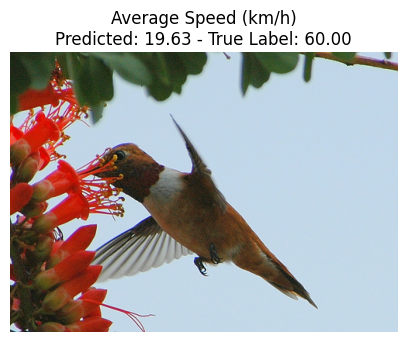

0.020016339869281044 Height Encoded
10.249999999999998
My prediction is 0.19286006689071655


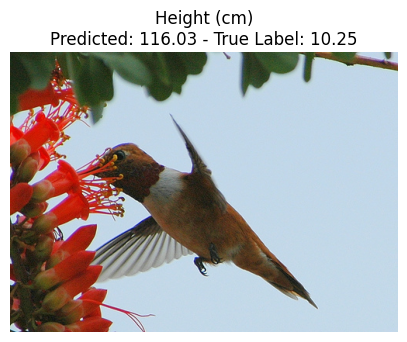

0.0029871323529411763 Weight Encoded
11.0
My prediction is 0.22274255752563477


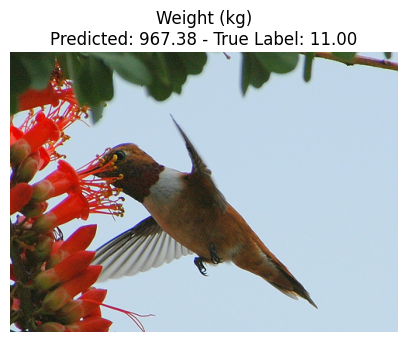

In [ ]:
random_image_path = random.choice(melted_df['ImagePath'])
example_df = melted_df[melted_df['ImagePath']==random_image_path]
to_concat = []
for i in desired_labels:
  to_concat.append(example_df[example_df['Tag']==i])
example_df = pd.concat(to_concat)

def display_predictions(df, model, feature_mapping, device='cuda'):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for _, row in df.iterrows():

        try:

            image_path = row['ImagePath']
            image = Image.open(image_path)
            image_tensor = transform(image).unsqueeze(0) #.to(device)

            tag_number = row['Tag']
            tag_name = [x for x in feature_mapping if feature_mapping[x]==tag_number][0]
            tag_tensor = torch.tensor(tag_number, dtype=torch.long).unsqueeze(0)#.to(device)
            print(row['Label'],tag_name.replace('Normalized','Encoded'))
            denormalized_true_label = denormalize(row["Label"], tag_name.replace('Normalized','Encoded'))
            print(denormalized_true_label)
            with torch.no_grad():
              prediction = model(image_tensor, tag_tensor).squeeze().item()
              denormalized_prediction = denormalize(prediction, tag_name.replace('Normalized','Encoded'))


            plt.figure(figsize=(5,5))
            plt.imshow(image)
            plt.axis('off')
            plt.title(f'{tag_titles[tag_name]}\nPredicted: {denormalized_prediction:.2f} - True Label: {denormalized_true_label:.2f}')
            plt.show()

        except Exception as e:
            print(f"An error occurred with image {image_path}: {e}")

tag_titles = {'AvgSpeed Normalized':'Average Speed (km/h)',
              'Height Normalized':'Height (cm)',
              'Weight Normalized':'Weight (kg)'}

print(model)
display_predictions(example_df, model, feature_mapping)

In [ ]:
test_df = melted_df[melted_df['Tag']==4].sample(frac=0.01)

test_data = ImageNetDataset(test_df, [4])
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

print(f"{len(test_df.index)} vs. {len(melted_df.index)}")

570 vs. 340662


In [ ]:
loss_fn = nn.MSELoss()

total_loss = 0.0
total_samples = 0

with torch.no_grad():
    for batch, (images, tags, labels) in enumerate(test_dataloader):
        predictions = model(images, tags.unsqueeze(-1))

        batch_loss = loss_fn(predictions.squeeze(), labels.float())
        total_loss += batch_loss.item() * labels.size(0)
        total_samples += labels.size(0)

average_loss = total_loss / total_samples

print(f"Average Loss on Test Dataset: {average_loss:.4f}")

Unreadable file skipped: /content/drive/My Drive/9.s912/animal-kingdom/imagenet_folders/n01833805_3473.JPEG
Average Loss on Test Dataset: 0.0606


In [ ]:
test_df = small_df.sample(frac=0.5)

test_data = ImageNetDataset(test_df, desired_labels)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

print(f"{len(test_df.index)} vs. {len(melted_df.index)}")

loss_fn = nn.MSELoss()

total_loss = 0.0
total_samples = 0

with torch.no_grad():
    for batch, (images, tags, labels) in enumerate(test_dataloader):
        predictions = model(images, tags.unsqueeze(-1))

        batch_loss = loss_fn(predictions.squeeze(), labels.float())
        total_loss += batch_loss.item() * labels.size(0)
        total_samples += labels.size(0)

average_loss = total_loss / total_samples

print(f"Average Loss on Test Dataset: {average_loss:.4f}")

1710 vs. 340662
Average Loss on Test Dataset: 0.0497


Evaluate model on 4th task.

In [ ]:
def load_checkpoint(checkpoint_path, model):
    """
    Loads a checkpoint into a model.
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)
    try:
      model.load_state_dict(checkpoint['model_state_dict'])
      print(f"Loading model from {checkpoint_path}")
      return model
    except Exception as e:
      print(f"Failed to load {checkpoint_path}: {e}")

def compute_loss_on_new_task(checkpoint, tag):
    tag_name = [x for x in feature_mapping if feature_mapping[x]==tag][0]
    print('---'*10+f'/nTag is {tag_name}')
    model = load_checkpoint(checkpoint_path, ReducedDistributedNet())
    tag_df = melted_df[melted_df['Tag']==tag].sample(frac=0.01)

    # Split the melted_df into training and testing datasets
    train_df, test_df = train_test_split(tag_df, test_size=0.2, random_state=42)

    # Create a testing dataset using the sampled test_df
    train_data = ImageNetDataset(train_df, [tag])
    train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_data = ImageNetDataset(test_df, [tag])
    test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)
    print(f"{len(train_dataloader)} testing samples and {len(test_dataloader)} testing samples")

    loss_fn = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=0.01)

    model.train()

    print('Now Training')

    for epoch in range(1):
        total_loss = 0.0

        for batch, (images, tags, labels) in enumerate(train_dataloader):
            # Move data to the same device as the model

            predictions = model(images, tags.unsqueeze(-1))

            loss = loss_fn(predictions.squeeze(), labels.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_dataloader)
        print(f"Epoch [{epoch+1}/3] Training Loss: {average_loss:.4f}")

        print('Now Testing')
        model.eval()

        all_predictions = []
        all_true_labels = []

        for batch, (images, tags, labels) in enumerate(test_dataloader):

            with torch.no_grad():
                predictions = model(images, tags.unsqueeze(-1))

            all_predictions.extend(predictions.squeeze().tolist())
            all_true_labels.extend(labels.tolist())

        mse = mean_squared_error(all_true_labels, all_predictions)
        print(f"Testing Mean Squared Error (MSE): {mse:.4f}")

In [ ]:
checkpoint_paths = [os.path.join(drive_path,'tiny_checkpoint_epoch_2.pth'),os.path.join(drive_path,'checkpoint_epoch_3.pth'),os.path.join(drive_path, 'gpu_epoch3_checkpoint.pth')]

In [ ]:
for checkpoint_path in checkpoint_paths:
  for tag in [1,3,4]:
    try:
      compute_loss_on_new_task(checkpoint_path, tag)
    except:
      print(f'Failed to train/test {tag} for {checkpoint_path}')

------------------------------/nTag is Gestation Normalized
Loading model from /content/drive/My Drive/9.s912/animal-kingdom/tiny_checkpoint_epoch_2.pth
14 testing samples and 4 testing samples
Now Training
Epoch [1/3] Training Loss: 0.0552
Now Testing
Testing Mean Squared Error (MSE): 0.0340
------------------------------/nTag is Lifespan Normalized
Loading model from /content/drive/My Drive/9.s912/animal-kingdom/tiny_checkpoint_epoch_2.pth
15 testing samples and 4 testing samples
Now Training
Epoch [1/3] Training Loss: 0.0461
Now Testing
Testing Mean Squared Error (MSE): 0.0473
------------------------------/nTag is TopSpeed Normalized
Loading model from /content/drive/My Drive/9.s912/animal-kingdom/tiny_checkpoint_epoch_2.pth
15 testing samples and 4 testing samples
Now Training
Epoch [1/3] Training Loss: 0.0487
Now Testing
Testing Mean Squared Error (MSE): 0.0358
------------------------------/nTag is Gestation Normalized
Loading model from /content/drive/My Drive/9.s912/animal-kin

## Specialized Net

Define architecture

In [ ]:
class SpecializedSubnet(nn.Module):
    def __init__(self):
        super(SpecializedSubnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        feature_size = 56*56*64
        self.fc1 = nn.Linear(feature_size, 1024)
        self.fc2 = nn.Linear(1024, 1)  # Single output neuron for regression
        self.dropout = nn.Dropout(0.5)
        self.max_pool = nn.MaxPool2d(2)

    def forward(self, x):
        # no feature tag in the Subnets
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
desired_labels

[0, 2, 5]

In [ ]:
# create a subnet module for each of the 3 initial training features
subnets = [SpecializedSubnet() for _ in range(3)]
trained_subnets = []

loss_fn = nn.MSELoss()

def subnet_train_loop(model, loss_fn, optimizer, train_dataloader):
    model.train()  # Set the model to training mode
    for batch, (images, tags, labels) in enumerate(train_dataloader):
        # Forward pass: compute the prediction and the loss
        pred = model(images)
        loss = loss_fn(pred, labels.float())   # Make sure labels are floats for regression

        # Backward pass: compute the gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 8 == 0:
            loss, current = loss.item(), batch * len(images)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(train_dataloader.dataset):>5d}]")
    save_checkpoint(subnet,optimizer,t+1,os.path.join(drive_path,f'subnet_{i+1}_epoch_{t+1}.pth'))
epochs = 3

for i, subnet in enumerate(subnets):
    # create a new training dataset with only the corresponding feature
    subnet_training_data = ImageNetDataset(melted_df.sample(frac=0.01), [desired_labels[i]])
    subnet_train_dataloader = DataLoader(subnet_training_data, batch_size=32, shuffle=True)
    subnet_optimizer = optim.Adam(subnet.parameters(), lr=0.001)
    for t in range(epochs):
        print(f"Subnetwork {i+1}, Epoch {t+1}\n-------------------------------")
        subnet_train_loop(subnet, loss_fn, subnet_optimizer, subnet_train_dataloader)
    trained_subnets.append(subnet)

Subnetwork 1, Epoch 1
-------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.102361  [    0/  598]
loss: 0.214114  [  256/  598]
loss: 0.103362  [  512/  598]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Subnetwork 1, Epoch 2
-------------------------------
loss: 0.165407  [    0/  598]
loss: 0.126987  [  256/  598]
loss: 0.110143  [  512/  598]
Subnetwork 1, Epoch 3
-------------------------------
loss: 0.159051  [    0/  598]
loss: 0.104202  [  256/  598]
loss: 0.118009  [  512/  598]
Subnetwork 2, Epoch 1
-------------------------------
loss: 0.059025  [    0/  607]
loss: 0.387333  [  256/  607]
loss: 0.073374  [  512/  607]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Subnetwork 2, Epoch 2
-------------------------------
loss: 0.067852  [    0/  607]
loss: 0.039546  [  256/  607]
loss: 0.170958  [  512/  607]
Subnetwork 2, Epoch 3
-------------------------------
loss: 0.082933  [    0/  607]
loss: 0.073474  [  256/  607]
loss: 0.043362  [  512/  607]
Subnetwork 3, Epoch 1
-------------------------------
loss: 0.005272  [    0/  542]
loss: 0.069137  [  256/  542]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.019755  [  480/  542]
Subnetwork 3, Epoch 2
-------------------------------
loss: 0.009118  [    0/  542]
loss: 0.040413  [  256/  542]
loss: 0.009356  [  480/  542]
Subnetwork 3, Epoch 3
-------------------------------
loss: 0.017286  [    0/  542]
loss: 0.061047  [  256/  542]
loss: 0.009930  [  480/  542]


In [ ]:
class SpecializedNet(nn.Module):
    def __init__(self, subnets):
        super(SpecializedNet, self).__init__()
        self.subnets = nn.ModuleList(subnets)
        self.fc1 = nn.Linear(1 * len(subnets) + 1, 64)  # +1 for the tag
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x, tag):
        # Collect outputs from each subnet
        subnet_outputs = [subnet(x) for subnet in self.subnets]
        # Concatenate the outputs
        x = torch.cat(subnet_outputs, dim=1)
        # Add the feature tag
        tag = tag.view(-1, 1).float()  # Reshape tag to have the same batch dimension as x
        x = torch.cat((x, tag), dim=1)  # Concatenate flattened image tensor and tag
        # Pass through the fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# create specialized net
sp_net = SpecializedNet(trained_subnets)

# freeze the subnets
for subnet in sp_net.subnets:
    for param in subnet.parameters():
        param.requires_grad = False

to_concat = []
for i in desired_labels:
  to_concat.append(melted_df[melted_df['Tag']==i].sample(frac=0.02))
small_df = pd.concat(to_concat)
print(f"{len(small_df.index)} vs. {len(melted_df.index)}")

training_data = ImageNetDataset(small_df,desired_labels)
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)

sp_net_optimizer = optim.Adam(sp_net.parameters(), lr=0.001)

# Define a regression loss function instead of CrossEntropyLoss
loss_fn = nn.MSELoss() #nn.CrossEntropyLoss()

# Training loop
def train_loop(model, loss_fn, optimizer, train_dataloader, l1_lambda=1e-5):
    model.to(device)
    model.train()  # Set the model to training mode
    for batch, (images, tags, labels) in enumerate(train_dataloader):

        images = images.to(device)
        labels = labels.to(device)
        tags = tags.to(device)
        # Forward pass: compute the prediction and the loss
        pred = model(images, tags.unsqueeze(-1))
        mse_loss = loss_fn(pred, labels.float())  # Mean Squared Error Loss

        # L1 Regularization
        l1_norm = sum(p.abs().sum() for p in model.parameters())

        # Total loss
        loss = mse_loss + l1_lambda * l1_norm

        # Backward pass: compute the gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 8 == 0:
            loss, current = loss.item(), batch * len(images)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(train_dataloader.dataset):>5d}]")

epochs = 3
# train the SpecializedNet end-to-end on all 3 features

for t in range(epochs):
    print(f"Specialized Net, Epoch {t+1}\n-------------------------------")
    train_loop(sp_net, loss_fn, sp_net_optimizer, train_dataloader)
    checkpoint_path = os.path.join(drive_path, f'specnet_checkpoint_epoch_{t+1}.pth')
    save_checkpoint(model, optimizer, t, checkpoint_path)
    print(f'Saved successfully as {checkpoint_path}')

3420 vs. 340662
Specialized Net, Epoch 1
-------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 30.324799  [    0/ 3420]
loss: 30.325453  [  256/ 3420]
loss: 30.305145  [  512/ 3420]
loss: 30.275919  [  768/ 3420]
loss: 30.301308  [ 1024/ 3420]
loss: 30.278463  [ 1280/ 3420]
loss: 30.322987  [ 1536/ 3420]
loss: 30.296883  [ 1792/ 3420]
loss: 30.276659  [ 2048/ 3420]
loss: 30.313410  [ 2304/ 3420]
loss: 30.315325  [ 2560/ 3420]
loss: 30.273224  [ 2816/ 3420]
loss: 30.275791  [ 3072/ 3420]
loss: 30.282162  [ 3328/ 3420]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


NameError: ignored

In [ ]:
random_image_path = random.choice(melted_df['ImagePath'])
example_df = melted_df[melted_df['ImagePath']==random_image_path]
to_concat = []
for i in desired_labels:
  to_concat.append(example_df[example_df['Tag']==i])
example_df = pd.concat(to_concat)

print(example_df)

print(example_df)
def display_predictions_for_subnet(df, model, tag_number, feature_mapping, device='cuda'):
    # Ensure the model is in evaluation mode
    model.eval()
    model.to(device)

    df = df[df['Tag']==tag_number]

    # Define the transformation applied to the images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to the input size expected by the model
        transforms.ToTensor(),  # Convert PIL image to a torch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
    ])

    # Loop over the DataFrame
    for _, row in df.iterrows():
        # print(row)
        try:
            # Load and transform the image
            image_path = row['ImagePath']
            image = Image.open(image_path)
            image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and send to device
            tag_name = [x for x in feature_mapping if feature_mapping[x]==tag_number][0]
            print(row['Label'],tag_name.replace('Normalized','Encoded'))
            denormalized_true_label = denormalize(row["Label"], tag_name.replace('Normalized','Encoded'))
            print(denormalized_true_label)
            # Get the model prediction
            # with torch.no_grad():
                # print('actually computing prediction')
            prediction = model(image_tensor).squeeze().item()  # Get the scalar value
            denormalized_prediction = denormalize(prediction, tag_name.replace('Normalized','Encoded'))

            # Display the image, prediction, and true label
            plt.figure(figsize=(5,5))  # Adjust the figure size as needed
            plt.imshow(image)
            plt.axis('off')  # Hide the axis numbers
            plt.title(f'{tag_titles[tag_name]}\nPredicted: {denormalized_prediction:.2f} - True Label: {denormalized_true_label:.2f}')
            plt.show()

        except Exception as e:
            print(f"An error occurred with image {image_path}: {e}")


tag_titles = {'AvgSpeed Normalized':'Average Speed (km/h)',
              'Height Normalized':'Height (cm)',
              'Weight Normalized':'Weight (kg)'}

for i, subnet in enumerate(trained_subnets):
  display_predictions_for_subnet(example_df, subnet, desired_labels[i], feature_mapping)


                                                ImagePath  Tag     Label
36657   /content/drive/My Drive/9.s912/animal-kingdom/...    0  0.245902
211524  /content/drive/My Drive/9.s912/animal-kingdom/...    2  0.200163
269813  /content/drive/My Drive/9.s912/animal-kingdom/...    5  0.056756
                                                ImagePath  Tag     Label
36657   /content/drive/My Drive/9.s912/animal-kingdom/...    0  0.245902
211524  /content/drive/My Drive/9.s912/animal-kingdom/...    2  0.200163
269813  /content/drive/My Drive/9.s912/animal-kingdom/...    5  0.056756
0.2459016393442623 AvgSpeed Encoded
30.0


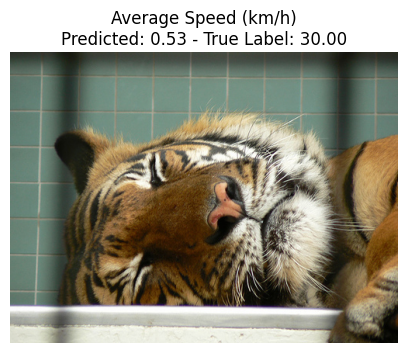

0.20016339869281047 Height Encoded
122.5


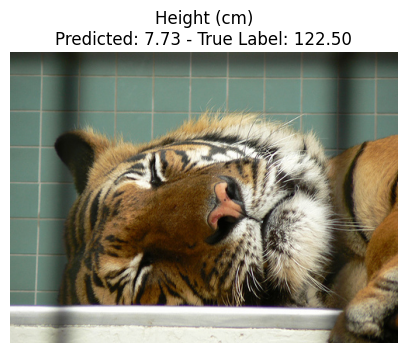

0.05675551470588235 Weight Encoded
247.0


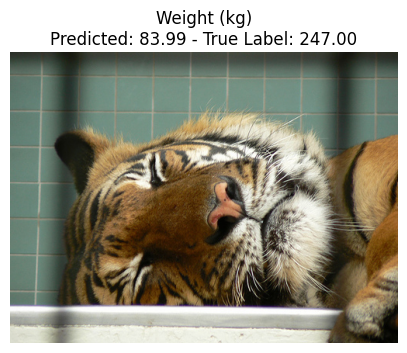

In [ ]:
random_image_path = random.choice(melted_df['ImagePath'])
example_df = melted_df[melted_df['ImagePath']==random_image_path]
to_concat = []
for i in desired_labels:
  to_concat.append(example_df[example_df['Tag']==i])
example_df = pd.concat(to_concat)

print(example_df)

print(example_df)
def display_predictions_for_subnet(df, model, tag_number, feature_mapping, device='cuda'):
    model.eval()
    model.to(device)

    df = df[df['Tag']==tag_number]

    # Define the transformation applied to the images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to the input size expected by the model
        transforms.ToTensor(),  # Convert PIL image to a torch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
    ])

    # Loop over the DataFrame
    for _, row in df.iterrows():
        # print(row)
        try:
            # Load and transform the image
            image_path = row['ImagePath']
            image = Image.open(image_path)
            image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and send to device
            tag_name = [x for x in feature_mapping if feature_mapping[x]==tag_number][0]
            print(row['Label'],tag_name.replace('Normalized','Encoded'))
            denormalized_true_label = denormalize(row["Label"], tag_name.replace('Normalized','Encoded'))
            print(denormalized_true_label)
            # Get the model prediction
            # with torch.no_grad():
                # print('actually computing prediction')
            prediction = model(image_tensor).squeeze().item()  # Get the scalar value
            denormalized_prediction = denormalize(prediction, tag_name.replace('Normalized','Encoded'))

            # Display the image, prediction, and true label
            plt.figure(figsize=(5,5))  # Adjust the figure size as needed
            plt.imshow(image)
            plt.axis('off')  # Hide the axis numbers
            plt.title(f'{tag_titles[tag_name]}\nPredicted: {denormalized_prediction:.2f} - True Label: {denormalized_true_label:.2f}')
            plt.show()

        except Exception as e:
            print(f"An error occurred with image {image_path}: {e}")


tag_titles = {'AvgSpeed Normalized':'Average Speed (km/h)',
              'Height Normalized':'Height (cm)',
              'Weight Normalized':'Weight (kg)'}

for i, subnet in enumerate(trained_subnets):
  display_predictions_for_subnet(example_df, subnet, desired_labels[i], feature_mapping)


# MNIST Dataset Experiment


## Prepare Data

Tasks:

*   Add 3
*   Multiply by 1.5
*   Square root
*   **Additional:** Square OR 2.3 * sqrt(x) - 1.4



In [ ]:
class TrainDataset(Dataset):
    def __init__(self, tasks_to_include):
        data = pd.read_csv('sample_data/mnist_train_small.csv', header=None)
        images, tags, labels = [], [], []
        for index, row in data.iterrows():
            for task_i in tasks_to_include:
                images.append(data.iloc[index, 1:].values.reshape(1, 28, 28).tolist())
                tags.append([task_i])
                number = data.iloc[index, 0]
                if task_i == 0:
                    labels.append([number + 3])
                elif task_i == 1:
                    labels.append([number * 1.5])
                elif task_i == 2:
                    labels.append([np.sqrt(number)])
                elif task_i == 3:                            # this is the fourth additional task
                    labels.append([2.3*np.sqrt(number)+1.4]) # change to np.square(number) for squaring
        self.images = torch.tensor(images).float().to(device)
        self.tags = torch.tensor(tags).float().to(device)
        self.labels = torch.tensor(labels).float().to(device)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.tags[idx], self.labels[idx]

In [ ]:
class TestDataset(Dataset):
    def __init__(self, tasks_to_include):
        data = pd.read_csv('sample_data/mnist_test.csv', header=None)
        images, tags, labels = [], [], []
        for index, row in data.iterrows():
            for task_i in tasks_to_include:
                images.append(data.iloc[index, 1:].values.reshape(1, 28, 28).tolist())
                tags.append([task_i])
                number = data.iloc[index, 0]
                if task_i == 0:
                    labels.append([number + 3])
                elif task_i == 1:
                    labels.append([number * 1.5])
                elif task_i == 2:
                    labels.append([np.sqrt(number)])
                elif task_i == 3:
                    labels.append([2.3*np.sqrt(number)+1.4])
        self.images = torch.tensor(images).float().to(device)
        self.tags = torch.tensor(tags).float().to(device)
        self.labels = torch.tensor(labels).float().to(device)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.tags[idx], self.labels[idx]

Create initial datasets with only the 3 initial tasks:

In [ ]:
train_dataset = TrainDataset(tasks_to_include=[0,1,2])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
test_dataset = TestDataset(tasks_to_include=[0,1,2])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Training Utilities

In [ ]:
def train_loop(model, loss_fn, optimizer, train_dataloader, train_with_tag=True):
    losses = [[], [], [], []]
    for batch, (image, tag, label) in enumerate(train_dataloader):
        if train_with_tag:
            pred = model(image, tag)
        else:
            pred = model(image)  # for the specialized subnetworks
        loss = loss_fn(pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            for t in range(4):
                losses[t].append(loss_fn(pred.flatten()[tag.flatten()==t], label.flatten()[tag.flatten()==t]).item())

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(image)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(train_dataloader.dataset):>5d}]")

    return losses

In [ ]:
loss_fn = nn.MSELoss()

## Distributed Net

In [ ]:
class DistributedNet(nn.Module):
    def __init__(self):
        super(DistributedNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(7*7*64 + 1, 1024)  # +1 for tag
        self.fc2 = nn.Linear(1024, 1)
        self.max_pool = nn.MaxPool2d(2)

    def forward(self, x, tag):
        x = torch.relu(self.conv1(x))
        x = self.max_pool(x)
        x = torch.relu(self.conv2(x))
        x = self.max_pool(x)
        x = x.view(-1, 7*7*64)
        x = torch.cat((x, tag), dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
dn_model = DistributedNet().to(device)
dn_optimizer = optim.Adam(dn_model.parameters(), lr=0.001)

epochs = 3
for t in range(epochs):
    print(f"Distributed Net, Epoch {t+1}\n-------------------------------")
    train_loop(dn_model, loss_fn, dn_optimizer, train_dataloader)

Distributed Net, Epoch 1
-------------------------------
loss: 243.330231  [    0/60000]
loss: 9.364307  [ 3200/60000]
loss: 11.079510  [ 6400/60000]
loss: 9.539282  [ 9600/60000]
loss: 7.529078  [12800/60000]
loss: 6.414670  [16000/60000]
loss: 3.770739  [19200/60000]
loss: 5.597565  [22400/60000]
loss: 5.630222  [25600/60000]
loss: 5.123975  [28800/60000]
loss: 5.289612  [32000/60000]
loss: 4.001102  [35200/60000]
loss: 4.567546  [38400/60000]
loss: 3.951569  [41600/60000]
loss: 3.993849  [44800/60000]
loss: 4.192879  [48000/60000]
loss: 3.059005  [51200/60000]
loss: 1.607348  [54400/60000]
loss: 6.454910  [57600/60000]
Distributed Net, Epoch 2
-------------------------------
loss: 4.616940  [    0/60000]
loss: 5.411300  [ 3200/60000]
loss: 3.892622  [ 6400/60000]
loss: 4.421241  [ 9600/60000]
loss: 4.753079  [12800/60000]
loss: 4.972533  [16000/60000]
loss: 2.883331  [19200/60000]
loss: 4.917715  [22400/60000]
loss: 3.663367  [25600/60000]
loss: 3.411571  [28800/60000]
loss: 3.45438

## Specialized Net

In [ ]:
class SpecializedSubnet(nn.Module):
    def __init__(self):
        super(SpecializedSubnet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        feature_size = 7*7*64
        self.fc1 = nn.Linear(feature_size, 1024)
        self.fc2 = nn.Linear(1024, 1)  # Single output neuron for regression
        self.max_pool = nn.MaxPool2d(2)

    def forward(self, x):
        # no feature tag in the Subnets
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# create a subnet module for each of the 3 initial training tasks
subnets = [SpecializedSubnet().to(device) for _ in range(3)]
trained_subnets = []
for i, subnet in enumerate(subnets):
    # create a new training dataset with only the corresponding task
    subnet_training_data = TrainDataset(tasks_to_include=[i])
    subnet_train_dataloader = DataLoader(subnet_training_data, batch_size=32, shuffle=True)
    subnet_optimizer = optim.Adam(subnet.parameters(), lr=0.001)
    epochs = 2
    for t in range(epochs):
        print(f"Subnetwork {i+1}, Epoch {t+1}\n-------------------------------")
        train_loop(subnet, loss_fn, subnet_optimizer, subnet_train_dataloader, train_with_tag=False)
    trained_subnets.append(subnet)

Subnetwork 1, Epoch 1
-------------------------------
loss: 9.891208  [    0/20000]
loss: 3.459840  [ 3200/20000]
loss: 2.316677  [ 6400/20000]
loss: 1.645339  [ 9600/20000]
loss: 1.399640  [12800/20000]
loss: 2.413993  [16000/20000]
loss: 0.730332  [19200/20000]
Subnetwork 1, Epoch 2
-------------------------------
loss: 1.150415  [    0/20000]
loss: 1.823921  [ 3200/20000]
loss: 1.390092  [ 6400/20000]
loss: 1.304428  [ 9600/20000]
loss: 0.961381  [12800/20000]
loss: 1.317844  [16000/20000]
loss: 1.042902  [19200/20000]
Subnetwork 2, Epoch 1
-------------------------------
loss: 103.484894  [    0/20000]
loss: 11.893473  [ 3200/20000]
loss: 11.228766  [ 6400/20000]
loss: 4.282852  [ 9600/20000]
loss: 4.357353  [12800/20000]
loss: 7.331673  [16000/20000]
loss: 5.938453  [19200/20000]
Subnetwork 2, Epoch 2
-------------------------------
loss: 6.061994  [    0/20000]
loss: 2.952667  [ 3200/20000]
loss: 2.665966  [ 6400/20000]
loss: 2.980953  [ 9600/20000]
loss: 2.151805  [12800/20000]


In [ ]:
class SpecializedNet(nn.Module):
    def __init__(self, subnets):
        super(SpecializedNet, self).__init__()
        self.subnets = nn.ModuleList(subnets)
        self.fc1 = nn.Linear(len(subnets) + 1, 64)  # one answer from each subnet, +1 for the tag
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x, tag):
        # Collect outputs from each subnet
        subnet_outputs = [subnet(x) for subnet in self.subnets]
        # Concatenate the outputs
        x = torch.cat(subnet_outputs, dim=1)
        # Add the feature tag
        x = torch.cat((x, tag), dim=1)  # Concatenate flattened image tensor and tag
        # Pass through the fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# create specialized net
sn_model = SpecializedNet(trained_subnets).to(device)

# freeze the subnets
for subnet in sn_model.subnets:
    for param in subnet.parameters():
        param.requires_grad = False

# train the SpecializedNet end-to-end on all 3 tasks to learn the fc layers
sn_optimizer = optim.Adam(sn_model.parameters(), lr=0.001)
for t in range(epochs):
    print(f"Specialized Net, Epoch {t+1}\n-------------------------------")
    train_loop(sn_model, loss_fn, sn_optimizer, train_dataloader)

Specialized Net, Epoch 1
-------------------------------
loss: 31.111965  [    0/60000]
loss: 7.322849  [ 3200/60000]
loss: 8.496395  [ 6400/60000]
loss: 3.013294  [ 9600/60000]
loss: 2.012076  [12800/60000]
loss: 3.148151  [16000/60000]
loss: 2.580057  [19200/60000]
loss: 3.732913  [22400/60000]
loss: 4.182908  [25600/60000]
loss: 2.774126  [28800/60000]
loss: 3.273292  [32000/60000]
loss: 2.197565  [35200/60000]
loss: 3.451937  [38400/60000]
loss: 3.840696  [41600/60000]
loss: 2.402047  [44800/60000]
loss: 1.989077  [48000/60000]
loss: 1.681812  [51200/60000]
loss: 2.087261  [54400/60000]
loss: 2.681237  [57600/60000]
Specialized Net, Epoch 2
-------------------------------
loss: 2.050665  [    0/60000]
loss: 2.053418  [ 3200/60000]
loss: 1.974168  [ 6400/60000]
loss: 1.453511  [ 9600/60000]
loss: 0.719763  [12800/60000]
loss: 1.307891  [16000/60000]
loss: 0.523386  [19200/60000]
loss: 2.388548  [22400/60000]
loss: 0.718014  [25600/60000]
loss: 1.522826  [28800/60000]
loss: 2.280678 

## Distributed Net with specialized architecture

In [ ]:
class DistributedNetSA(nn.Module):
    def __init__(self):
        super(DistributedNetSA, self).__init__()
        self.subnets = nn.ModuleList([SpecializedSubnet() for _ in range(3)])
        self.fc1 = nn.Linear(3 + 1, 64)  # one answer from each subnet, +1 for the tag
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x, tag):
        # Collect outputs from each subnet
        subnet_outputs = [subnet(x) for subnet in self.subnets]
        # Concatenate the outputs
        x = torch.cat(subnet_outputs, dim=1)
        # Add the feature tag
        x = torch.cat((x, tag), dim=1)  # Concatenate flattened image tensor and tag
        # Pass through the fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
dnsa_model = DistributedNetSA().to(device)
dnsa_optimizer = optim.Adam(dnsa_model.parameters(), lr=0.001)

epochs = 3
for t in range(epochs):
    print(f"Distributed Net specialized architecture, Epoch {t+1}\n-------------------------------")
    train_loop(dnsa_model, loss_fn, dnsa_optimizer, train_dataloader)

## Evaluation

**IMPORTANT NOTE:** To use the distributed net with specialized architecture, uncomment the line below. Otherwise, leave it commented. Running the rest of the notebook will generate plots for initial evaluation on 3 training tasks, train the networks on the final fourth task, and generate plots for post-training performance.

In [ ]:
# dn_model = dnsa_model

In [ ]:
# compute the average MSE loss on each of the 3 tasks
dn_losses = [[], [], []]
sn_losses = [[], [], []]
subnet_losses = [[], [], []]

with torch.no_grad():
    for batch, (image, tag, label) in enumerate(test_dataloader):
        flat_tag = tag.flatten()
        flat_label = label.flatten()

        dn_pred = dn_model(image, tag).flatten()
        for t in range(3):
            dn_losses[t].append(loss_fn(dn_pred[flat_tag==t], flat_label[flat_tag==t]).item())

        sn_pred = sn_model(image, tag).flatten()
        for t in range(3):
            sn_losses[t].append(loss_fn(sn_pred[flat_tag==t], flat_label[flat_tag==t]).item())

        for t in range(3):
            subnet_pred = trained_subnets[t](image[flat_tag==t]).flatten()
            subnet_losses[t].append(loss_fn(subnet_pred, flat_label[flat_tag==t]).item())

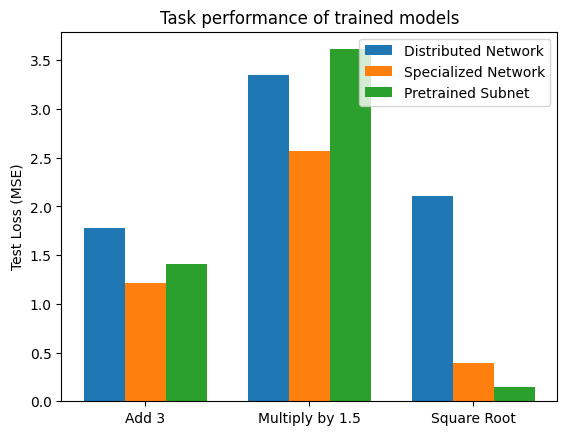

In [ ]:
width = 0.25
bar_mult = 0
modelns = ['Distributed Network', 'Specialized Network', 'Pretrained Subnet']
for modeln, losses in zip(modelns, [dn_losses, sn_losses, subnet_losses]):
    offset = width * bar_mult
    plt.bar(np.arange(3) + offset, [np.mean(l) for l in losses], width, label=modeln)
    bar_mult += 1
plt.title('Task performance of trained models')
plt.ylabel('Test Loss (MSE)')
plt.xticks(np.arange(3) + width, ['Add 3', 'Multiply by 1.5', 'Square Root'])
plt.legend()
plt.show()

## Adding a fourth task

In [ ]:
# create expanded dataset with the fourth task included
new_train_dataset = TrainDataset(tasks_to_include=[0,1,2,3])
new_train_dataloader = DataLoader(new_train_dataset, batch_size=32, shuffle=True)

new_test_dataset = TestDataset(tasks_to_include=[0,1,2,3])
new_test_dataloader = DataLoader(new_test_dataset, batch_size=32, shuffle=False)

In [ ]:
import copy
new_dn_model = copy.deepcopy(dn_model).to(device)
new_dn_optimizer = optim.Adam(new_dn_model.parameters(), lr=0.005)

In [ ]:
new_sn_model = copy.deepcopy(sn_model).to(device)
new_sn_optimizer = optim.Adam(new_sn_model.parameters(), lr=0.005)

In [ ]:
dn_train_losses = [[], [], [], []]
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    task_losses = train_loop(new_dn_model, loss_fn, new_dn_optimizer, new_train_dataloader)
    for i in range(len(task_losses)):
        dn_train_losses[i].extend(task_losses[i])

Epoch 1
-------------------------------
loss: 17.099743  [    0/80000]
loss: 8.292675  [ 3200/80000]
loss: 7.415127  [ 6400/80000]
loss: 8.655972  [ 9600/80000]
loss: 5.450246  [12800/80000]
loss: 8.403496  [16000/80000]
loss: 8.282198  [19200/80000]
loss: 8.663848  [22400/80000]
loss: 7.332042  [25600/80000]
loss: 9.792455  [28800/80000]
loss: 7.574615  [32000/80000]
loss: 5.474550  [35200/80000]
loss: 5.237700  [38400/80000]
loss: 8.862499  [41600/80000]
loss: 6.598942  [44800/80000]
loss: 7.664929  [48000/80000]
loss: 7.802258  [51200/80000]
loss: 4.554870  [54400/80000]
loss: 5.118163  [57600/80000]
loss: 9.085905  [60800/80000]
loss: 6.776710  [64000/80000]
loss: 5.143821  [67200/80000]
loss: 4.876376  [70400/80000]
loss: 5.235341  [73600/80000]
loss: 5.841093  [76800/80000]


In [ ]:
# unfreeze everything, including the subnets
for subnet in new_sn_model.subnets:
    for param in subnet.parameters():
        param.requires_grad = True

In [ ]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(new_sn_model, loss_fn, new_sn_optimizer, new_train_dataloader)

Epoch 1
-------------------------------
loss: 2.553246  [    0/80000]
loss: 7.765258  [ 3200/80000]
loss: 9.087984  [ 6400/80000]
loss: 7.442317  [ 9600/80000]
loss: 4.456504  [12800/80000]
loss: 8.078384  [16000/80000]
loss: 5.403512  [19200/80000]
loss: 3.634827  [22400/80000]
loss: 6.392121  [25600/80000]
loss: 4.401762  [28800/80000]
loss: 2.983250  [32000/80000]
loss: 2.976850  [35200/80000]
loss: 1.703426  [38400/80000]
loss: 1.232106  [41600/80000]
loss: 2.416710  [44800/80000]
loss: 1.437866  [48000/80000]
loss: 1.404158  [51200/80000]
loss: 0.809679  [54400/80000]
loss: 1.537705  [57600/80000]
loss: 1.234794  [60800/80000]
loss: 0.751299  [64000/80000]
loss: 1.556248  [67200/80000]
loss: 0.497120  [70400/80000]
loss: 0.955953  [73600/80000]
loss: 1.261544  [76800/80000]


In [ ]:
# compute the average MSE loss on each of the 4 tasks
new_dn_losses = [[], [], [], []]
new_sn_losses = [[], [], [], []]

with torch.no_grad():
    for batch, (image, tag, label) in enumerate(new_test_dataloader):
        flat_tag = tag.flatten()
        flat_label = label.flatten()

        dn_pred = new_dn_model(image, tag).flatten()
        for t in range(4):
            new_dn_losses[t].append(loss_fn(dn_pred[flat_tag==t], flat_label[flat_tag==t]).item())

        sn_pred = new_sn_model(image, tag).flatten()
        for t in range(4):
            new_sn_losses[t].append(loss_fn(sn_pred[flat_tag==t], flat_label[flat_tag==t]).item())

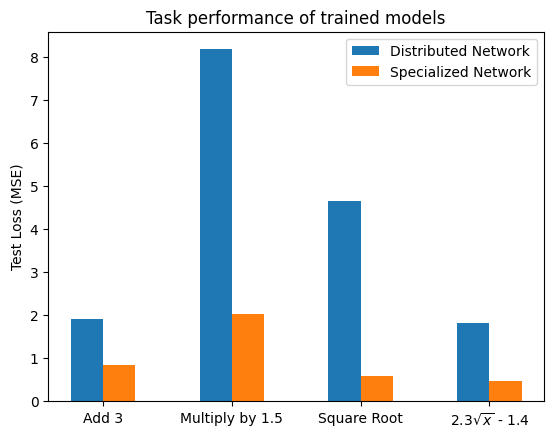

In [ ]:
width = 0.25
bar_mult = 0
modelns = ['Distributed Network', 'Specialized Network']
for modeln, losses in zip(modelns, [new_dn_losses, new_sn_losses]):
    offset = width * bar_mult
    plt.bar(np.arange(4) + offset, [np.mean(l) for l in losses], width, label=modeln)
    bar_mult += 1
plt.title('Task performance of trained models')
plt.ylabel('Test Loss (MSE)')
plt.xticks(np.arange(4)+width/2, ['Add 3', 'Multiply by 1.5', 'Square Root', '2.3$\sqrt{x}$ - 1.4'])
plt.legend()
plt.show()